<a href="https://colab.research.google.com/github/limestonestreams/thesis/blob/master/GloVe_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing my RData objects:

In [22]:
import pandas as pd

sentences = pd.read_feather("sentences.feather")

Subsetting to a dataset with speeches only by the US and Russia:

In [24]:
data = sentences.loc[sentences['country'].isin(['United States Of America', 'Russian Federation'])]
print(data['country'])

print(data['country'].value_counts())
data["country"] = data["country"].astype('category')
data["country"] = data["country"].cat.codes
print(data["country"].value_counts())

# 129 - Russia
# 169 - US

data.loc[data['country'] == 129, 'country'] = 1
data.loc[data['country'] == 169, 'country'] = 0
print(data["country"].value_counts())

# 1 - Russia
# 0 - US

120       Russian Federation
121       Russian Federation
122       Russian Federation
123       Russian Federation
124       Russian Federation
                 ...        
430449    Russian Federation
430450    Russian Federation
430451    Russian Federation
430452    Russian Federation
430453    Russian Federation
Name: country, Length: 50871, dtype: category
Categories (179, object): [Afghanistan, Albania, Algeria, Angola, ..., Yemen, Yugoslavia, Zambia, Zimbabwe]
United States Of America    26900
Russian Federation          23971
Zimbabwe                        0
Finland                         0
Guatemala                       0
                            ...  
Norway                          0
Nigeria                         0
Niger                           0
Nicaragua                       0
Afghanistan                     0
Name: country, Length: 179, dtype: int64
169    26900
129    23971
Name: country, dtype: int64
0    26900
1    23971
Name: country, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Splitting into training and testing set:

In [25]:
from sklearn.model_selection import train_test_split

s = data['text'].values
y = data['country'].values

s_train, s_test, y_train, y_test = train_test_split(s, y, test_size = 0.2, random_state = 1000)

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(s_train)

X_train = tokenizer.texts_to_sequences(s_train)
X_test = tokenizer.texts_to_sequences(s_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(s_train[2])
print(X_train[2])

Despite the fact that the report rightly calls Ukrainian society bilingual, the true position of the Russian-speaking population is not reflected in it at all.
[405, 1, 213, 6, 1, 79, 2976, 707, 243, 430, 1, 1079, 376, 2, 1, 82, 1476, 418, 10, 24, 1352, 5, 17, 46, 30]


Padding sentences:

In [26]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding = 'post', maxlen = maxlen)

print(X_train[0, :])

[1127    1   14   27   70   41  162  593  202  938    6  548  123  198
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Keras model setup:

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1]  # Number of features

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           964300    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,014,321
Trainable params: 1,014,321
Non-trainable params: 0
_________________________________________________________________


Keras model fit:

In [43]:
history = model.fit(X_train, y_train, batch_size = 50, epochs = 50, verbose = True, validation_data = (X_test, y_test))

Epoch 1/50
814/814 [==============================] - 4s 5ms/step - loss: 0.0246 - accuracy: 0.9963 - val_loss: 0.7974 - val_accuracy: 0.7959
Epoch 2/50
814/814 [==============================] - 4s 5ms/step - loss: 0.0260 - accuracy: 0.9954 - val_loss: 0.8006 - val_accuracy: 0.7947
Epoch 3/50
814/814 [==============================] - 4s 5ms/step - loss: 0.0300 - accuracy: 0.9939 - val_loss: 0.7956 - val_accuracy: 0.7945
Epoch 4/50
814/814 [==============================] - 4s 5ms/step - loss: 0.0237 - accuracy: 0.9959 - val_loss: 0.8916 - val_accuracy: 0.7826
Epoch 5/50
814/814 [==============================] - 4s 5ms/step - loss: 0.0240 - accuracy: 0.9957 - val_loss: 0.8136 - val_accuracy: 0.7952
Epoch 6/50
814/814 [==============================] - 4s 5ms/step - loss: 0.0232 - accuracy: 0.9965 - val_loss: 0.8642 - val_accuracy: 0.7872
Epoch 7/50
814/814 [==============================] - 4s 5ms/step - loss: 0.0225 - accuracy: 0.9964 - val_loss: 0.8572 - val_accuracy: 0.7868
Epoch 

Model evaluation:

In [44]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9989
Testing Accuracy:  0.7904


Confusion matrix:

In [45]:
# confusion matrix
from sklearn.metrics import confusion_matrix

pred_labels = model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, pred_labels)

print(conf_matrix)

[[4348 1044]
 [1089 3694]]


Plotting model evaluation:

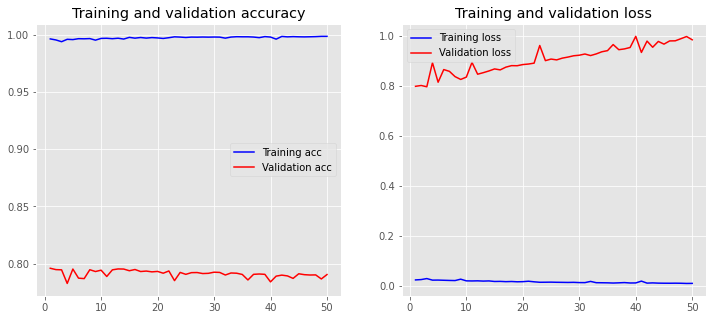

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)